In [1]:
import torch
import wandb
import sys
from configmypy import ConfigPipeline, YamlConfig, ArgparseConfig
from neuralop import get_model
from neuralop import Trainer
from neuralop.training import setup
from neuralop.datasets import load_darcy_pt
from neuralop.utils import get_wandb_api_key, count_params
from neuralop import LpLoss, H1Loss

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c105ErrorC2ENS_14SourceLocationESs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
for i in range(8, 34, 2):
    # Read the configuration
    config_name = 'default'
    pipe = ConfigPipeline([YamlConfig('./tfno_darcy_config.yaml', config_name='default', config_folder='./config'),
                          ])
    config = pipe.read_conf()
    config_name = pipe.steps[-1].config_name
    
    config.tfno2d.n_modes_height = i
    config.tfno2d.n_modes_width = i
    
    # Set-up distributed communication, if using
    device, is_logger = setup(config)
    
    # Make sure we only print information when needed
    config.verbose = config.verbose and is_logger

    #Print config to screen
    if config.verbose and is_logger:
        pipe.log()
        sys.stdout.flush()
    
    # Loading the Darcy flow training set in 32x32 resolution, test set in 32x32 and 64x64 resolutions
    train_loader, test_loaders, output_encoder = load_darcy_pt(
            config.data.folder, train_resolution=config.data.train_resolution, n_train=config.data.n_train, batch_size=config.data.batch_size, 
            positional_encoding=config.data.positional_encoding,
            test_resolutions=config.data.test_resolutions, n_tests=config.data.n_tests, test_batch_sizes=config.data.test_batch_sizes,
            encode_input=config.data.encode_input, encode_output=config.data.encode_output,
            )
    
    model = get_model(config)
    model = model.to(device)

    #Log parameter count
    if is_logger:
        n_params = count_params(model)

        if config.verbose:
            print(f'\nn_params: {n_params}')
            sys.stdout.flush()
    
    #Create the optimizer
    optimizer = torch.optim.Adam(model.parameters(), 
                                    lr=config.opt.learning_rate, 
                                    weight_decay=config.opt.weight_decay)

    if config.opt.scheduler == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=config.opt.gamma, patience=config.opt.scheduler_patience, mode='min')
    elif config.opt.scheduler == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.opt.scheduler_T_max)
    elif config.opt.scheduler == 'StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                                    step_size=config.opt.step_size,
                                                    gamma=config.opt.gamma)
    else:
        raise ValueError(f'Got {config.opt.scheduler=}')
    
    # Creating the losses
    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)
    if config.opt.training_loss == 'l2':
        train_loss = l2loss
    elif config.opt.training_loss == 'h1':
        train_loss = h1loss
    else:
        raise ValueError(f'Got training_loss={config.opt.training_loss} but expected one of ["l2", "h1"]')
    eval_losses={'h1': h1loss, 'l2': l2loss}
    
    if config.verbose and is_logger:
        print('\n### MODEL ###\n', model)
        print('\n### OPTIMIZER ###\n', optimizer)
        print('\n### SCHEDULER ###\n', scheduler)
        print('\n### LOSSES ###')
        print(f'\n * Train: {train_loss}')
        print(f'\n * Test: {eval_losses}')
        print(f'\n### Beginning Training...\n')
        sys.stdout.flush()
    
    trainer = Trainer(model, n_epochs=config.opt.n_epochs,
                      device=device,
                      mg_patching_levels=config.patching.levels,
                      mg_patching_padding=config.patching.padding,
                      mg_patching_stitching=config.patching.stitching,
                      wandb_log=config.wandb.log,
                      log_test_interval=config.wandb.log_test_interval,
                      log_output=False,
                      use_distributed=config.distributed.use_distributed,
                      verbose=config.verbose and is_logger)
    
    trainer.train(train_loader, test_loaders,
                  output_encoder,
                  model, 
                  optimizer,
                  scheduler, 
                  regularizer=False, 
                  training_loss=train_loss,
                  eval_losses=eval_losses)

###############################
#####    CONFIGURATION    #####
###############################

Steps:
------
 (1) YamlConfig with config_file=./tfno_darcy_config.yaml, config_name=default, config_folder=./config

-------------------------------

Configuration:
--------------

verbose=True
arch=tfno2d
distributed.use_distributed=False
tfno2d.lifting_channels=32
tfno2d.data_channels=3
tfno2d.n_modes_height=8
tfno2d.n_modes_width=8
tfno2d.hidden_channels=32
tfno2d.projection_channels=32
tfno2d.n_layers=4
tfno2d.domain_padding=None
tfno2d.domain_padding_mode=one-sided
tfno2d.fft_norm=forward
tfno2d.norm=None
tfno2d.skip=linear
tfno2d.implementation=factorized
tfno2d.separable=0
tfno2d.preactivation=0
tfno2d.use_mlp=1
tfno2d.mlp.expansion=0.5
tfno2d.mlp.dropout=0
tfno2d.factorization=tucker
tfno2d.rank=0.2
tfno2d.fixed_rank_modes=None
tfno2d.dropout=0.0
tfno2d.tensor_lasso_penalty=0.0
tfno2d.joint_factorization=False
opt.n_epochs=150
opt.learning_rate=0.005
opt.training_loss=h1
opt.weight

In [6]:
import numpy as np
for i in np.arange(0.01, 0.11, 0.01):
    # Read the configuration
    config_name = 'default'
    pipe = ConfigPipeline([YamlConfig('./tfno_darcy_config.yaml', config_name='default', config_folder='./config'),
                          ])
    config = pipe.read_conf()
    config_name = pipe.steps[-1].config_name
    
    config.tfno2d.rank = i
    
    # Set-up distributed communication, if using
    device, is_logger = setup(config)
    
    # Make sure we only print information when needed
    config.verbose = config.verbose and is_logger

    #Print config to screen
    if config.verbose and is_logger:
        pipe.log()
        sys.stdout.flush()
    
    # Loading the Darcy flow training set in 32x32 resolution, test set in 32x32 and 64x64 resolutions
    train_loader, test_loaders, output_encoder = load_darcy_pt(
            config.data.folder, train_resolution=config.data.train_resolution, n_train=config.data.n_train, batch_size=config.data.batch_size, 
            positional_encoding=config.data.positional_encoding,
            test_resolutions=config.data.test_resolutions, n_tests=config.data.n_tests, test_batch_sizes=config.data.test_batch_sizes,
            encode_input=config.data.encode_input, encode_output=config.data.encode_output,
            )
    
    model = get_model(config)
    model = model.to(device)

    #Log parameter count
    if is_logger:
        n_params = count_params(model)

        if config.verbose:
            print(f'\nn_params: {n_params}')
            sys.stdout.flush()
    
    #Create the optimizer
    optimizer = torch.optim.Adam(model.parameters(), 
                                    lr=config.opt.learning_rate, 
                                    weight_decay=config.opt.weight_decay)

    if config.opt.scheduler == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=config.opt.gamma, patience=config.opt.scheduler_patience, mode='min')
    elif config.opt.scheduler == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.opt.scheduler_T_max)
    elif config.opt.scheduler == 'StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                                    step_size=config.opt.step_size,
                                                    gamma=config.opt.gamma)
    else:
        raise ValueError(f'Got {config.opt.scheduler=}')
    
    # Creating the losses
    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)
    if config.opt.training_loss == 'l2':
        train_loss = l2loss
    elif config.opt.training_loss == 'h1':
        train_loss = h1loss
    else:
        raise ValueError(f'Got training_loss={config.opt.training_loss} but expected one of ["l2", "h1"]')
    eval_losses={'h1': h1loss, 'l2': l2loss}
    
    if config.verbose and is_logger:
        print('\n### MODEL ###\n', model)
        print('\n### OPTIMIZER ###\n', optimizer)
        print('\n### SCHEDULER ###\n', scheduler)
        print('\n### LOSSES ###')
        print(f'\n * Train: {train_loss}')
        print(f'\n * Test: {eval_losses}')
        print(f'\n### Beginning Training...\n')
        sys.stdout.flush()
    
    trainer = Trainer(model, n_epochs=config.opt.n_epochs,
                      device=device,
                      mg_patching_levels=config.patching.levels,
                      mg_patching_padding=config.patching.padding,
                      mg_patching_stitching=config.patching.stitching,
                      wandb_log=config.wandb.log,
                      log_test_interval=config.wandb.log_test_interval,
                      log_output=False,
                      use_distributed=config.distributed.use_distributed,
                      verbose=config.verbose and is_logger)
    
    trainer.train(train_loader, test_loaders,
                  output_encoder,
                  model, 
                  optimizer,
                  scheduler, 
                  regularizer=False, 
                  training_loss=train_loss,
                  eval_losses=eval_losses)

###############################
#####    CONFIGURATION    #####
###############################

Steps:
------
 (1) YamlConfig with config_file=./tfno_darcy_config.yaml, config_name=default, config_folder=./config

-------------------------------

Configuration:
--------------

verbose=True
arch=tfno2d
distributed.use_distributed=False
tfno2d.lifting_channels=32
tfno2d.data_channels=3
tfno2d.n_modes_height=12
tfno2d.n_modes_width=12
tfno2d.hidden_channels=32
tfno2d.projection_channels=32
tfno2d.n_layers=4
tfno2d.domain_padding=None
tfno2d.domain_padding_mode=one-sided
tfno2d.fft_norm=forward
tfno2d.norm=None
tfno2d.skip=linear
tfno2d.implementation=factorized
tfno2d.separable=0
tfno2d.preactivation=0
tfno2d.use_mlp=1
tfno2d.mlp.expansion=0.5
tfno2d.mlp.dropout=0
tfno2d.factorization=tucker
tfno2d.rank=0.01
tfno2d.fixed_rank_modes=None
tfno2d.dropout=0.0
tfno2d.tensor_lasso_penalty=0.0
tfno2d.joint_factorization=False
opt.n_epochs=150
opt.learning_rate=0.005
opt.training_loss=h1
opt.wei

# _________________
# Begin HW4 plot

In [1]:
import numpy as np
import pandas as pd

In [12]:
df_1 = pd.DataFrame(np.array([[8, (0.0856+0.0861)/2, (0.0416+0.0421)/2, (0.1813+0.1725)/2, (0.0597+0.0607)/2],
                              [10, (0.0752+0.0735)/2, (0.0360+0.0338)/2, (0.1653+0.1659)/2, (0.0531+0.0534)/2],
                              [12, (0.0722+0.0718)/2, (0.0355+0.0337)/2, (0.1565+0.1614)/2, (0.0485+0.0522)/2],
                              [14, (0.0748+0.0743)/2, (0.0351+0.0356)/2, (0.1627+0.1596)/2, (0.0518+0.0521)/2],
                              [16, (0.0727+0.0734)/2, (0.0341+0.0357)/2, (0.1606+0.1554)/2, (0.0544+0.0516)/2],
                              [18, (0.0769+0.0780)/2, (0.0386+0.0385)/2, (0.1594+0.1608)/2, (0.0527+0.0580)/2],
                              [20, (0.0797+0.0786)/2, (0.0413+0.0370)/2, (0.1560+0.1603)/2, (0.0533+0.0526)/2],
                              [22, (0.0803+0.0766)/2, (0.0406+0.0363)/2, (0.1589+0.1659)/2, (0.0573+0.0566)/2],
                              [24, (0.0776+0.0775)/2, (0.0354+0.0354)/2, (0.1622+0.1587)/2, (0.0528+0.0509)/2],
                              [26, (0.0777+0.0786)/2, (0.0355+0.0367)/2, (0.1626+0.1623)/2, (0.0530+0.0488)/2],
                              [28, (0.0772+0.0780)/2, (0.0362+0.0363)/2, (0.1497+0.1595)/2, (0.0484+0.0569)/2],
                              [30, (0.0774+0.0776)/2, (0.0356+0.0360)/2, (0.1647+0.1658)/2, (0.0540+0.0548)/2],
                              [32, (0.0769+0.0773)/2, (0.0354+0.0355)/2, (0.1835+0.1762)/2, (0.0537+0.0534)/2]]),
                    columns=['n_modes', '32_h1', '32_l2', '64_h1', '64_l2'])

In [13]:
df_1

,n_modes,32_h1,32_l2,64_h1,64_l2
0,8.0,0.08585,0.04185,0.17690,0.06020
1,10.0,0.07435,0.03490,0.16560,0.05325
2,12.0,0.07200,0.03460,0.15895,0.05035
3,14.0,0.07455,0.03535,0.16115,0.05195
4,16.0,0.07305,0.03490,0.15800,0.05300
5,18.0,0.07745,0.03855,0.16010,0.05535
6,20.0,0.07915,0.03915,0.15815,0.05295
7,22.0,0.07845,0.03845,0.16240,0.05695
8,24.0,0.07755,0.03540,0.16045,0.05185
9,26.0,0.07815,0.03610,0.16245,0.05090


array([<AxesSubplot:xlabel='n_modes'>, <AxesSubplot:xlabel='n_modes'>,
       <AxesSubplot:xlabel='n_modes'>, <AxesSubplot:xlabel='n_modes'>],
      dtype=object)

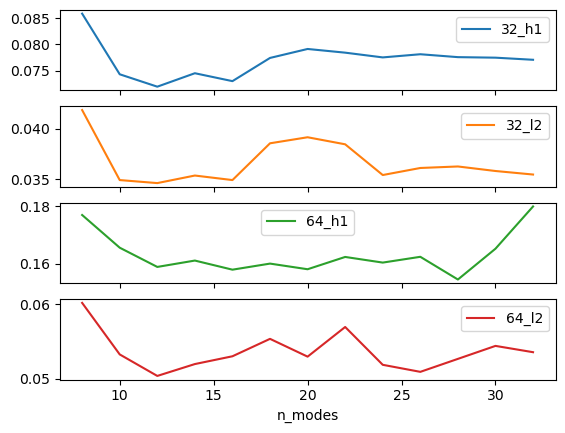

In [15]:
df_1.plot.line(x='n_modes', subplots=True)

In [30]:
df_2 = pd.DataFrame(np.array([[0.01, 19537, (0.0875+0.0916)/2, (0.0441+0.0508)/2, (0.1798+0.1738)/2, (0.0581+0.0628)/2],
                              [0.02, 26497, (0.0754+0.0719)/2, (0.0370+0.0334)/2, (0.1623+0.1590)/2, (0.0572+0.0497)/2],
                              [0.03, 30849, (0.0773+0.0726)/2, (0.0396+0.0348)/2, (0.1570+0.1598)/2, (0.0493+0.0488)/2],
                              [0.04, 35713, (0.0736+0.0749)/2, (0.0373+0.0393)/2, (0.1626+0.1595)/2, (0.0518+0.0525)/2],
                              [0.05, 38337, (0.0734+0.0789)/2, (0.0353+0.0426)/2, (0.1628+0.1620)/2, (0.0513+0.0564)/2],
                              [0.06, 56961, (0.0710+0.0715)/2, (0.0338+0.0339)/2, (0.1566+0.1594)/2, (0.0482+0.0536)/2],
                              [0.07, 62161, (0.0710+0.0710)/2, (0.0331+0.0339)/2, (0.1665+0.1644)/2, (0.0523+0.0502)/2],
                              [0.08, 62161, (0.0716+0.0704)/2, (0.0344+0.0330)/2, (0.1562+0.1611)/2, (0.0541+0.0532)/2],
                              [0.09, 67649, (0.0711+0.0713)/2, (0.0337+0.0351)/2, (0.1612+0.1584)/2, (0.0534+0.0522)/2],
                              [0.1, 67649, (0.0709+0.0712)/2, (0.0343+0.0341)/2, (0.1579+0.1616)/2, (0.0514+0.0486)/2],
                              [0.2, 137473, (0.0724+0.0750)/2, (0.0359+0.0359)/2, (0.1545+0.1630)/2, (0.0497+0.0505)/2],
                              [0.3, 173569, (0.0724+0.0746)/2, (0.0350+0.0353)/2, (0.1692+0.1633)/2, (0.0557+0.0496)/2],
                              [0.4, 290385, (0.0779+0.0762)/2, (0.0394+0.0368)/2, (0.1574+0.1655)/2, (0.0500+0.0549)/2],
                              [0.5, 311809, (0.0760+0.0776)/2, (0.0353+0.0368)/2, (0.1633+0.1683)/2, (0.0508+0.0562)/2],
                              [0.6, 357057, (0.0785+0.0795)/2, (0.0373+0.0388)/2, (0.1661+0.1641)/2, (0.0501+0.0529)/2],
                              [0.7, 380881, (0.0780+0.0778)/2, (0.0359+0.0368)/2, (0.1682+0.1716)/2, (0.0536+0.0541)/2],
                              [0.8, 564097, (0.0824+0.0814)/2, (0.0392+0.0402)/2, (0.1708+0.1702)/2, (0.0526+0.0550)/2],
                              [0.9, 600257, (0.0799+0.0819)/2, (0.0365+0.0385)/2, (0.1676+0.1749)/2, (0.0533+0.0580)/2]]),
                    columns=['tfno2d.rank', 'n_params', '32_h1', '32_l2', '64_h1', '64_l2'])

In [31]:
df_2

,tfno2d.rank,n_params,32_h1,32_l2,64_h1,64_l2
0,0.01,19537.0,0.08955,0.04745,0.17680,0.06045
1,0.02,26497.0,0.07365,0.03520,0.16065,0.05345
2,0.03,30849.0,0.07495,0.03720,0.15840,0.04905
3,0.04,35713.0,0.07425,0.03830,0.16105,0.05215
4,0.05,38337.0,0.07615,0.03895,0.16240,0.05385
5,0.06,56961.0,0.07125,0.03385,0.15800,0.05090
6,0.07,62161.0,0.07100,0.03350,0.16545,0.05125
7,0.08,62161.0,0.07100,0.03370,0.15865,0.05365
8,0.09,67649.0,0.07120,0.03440,0.15980,0.05280
9,0.10,67649.0,0.07105,0.03420,0.15975,0.05000


array([<AxesSubplot:xlabel='n_params'>, <AxesSubplot:xlabel='n_params'>,
       <AxesSubplot:xlabel='n_params'>, <AxesSubplot:xlabel='n_params'>],
      dtype=object)

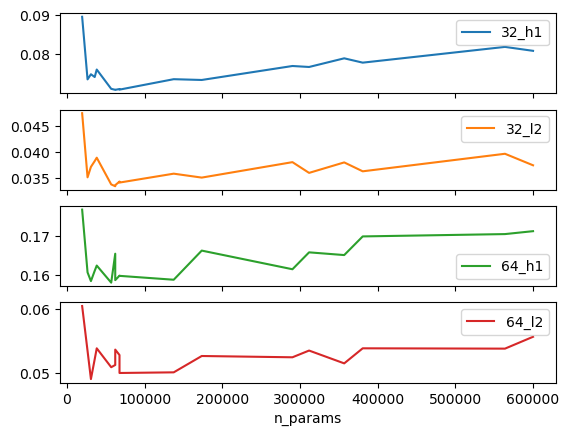

In [35]:
df_2.drop(columns=['tfno2d.rank']).plot.line(x='n_params', subplots=True)

In [36]:
df_3 = pd.DataFrame(np.array([[0.01, 19537, (0.0875+0.0916)/2, (0.0441+0.0508)/2, (0.1798+0.1738)/2, (0.0581+0.0628)/2],
                              [0.02, 26497, (0.0754+0.0719)/2, (0.0370+0.0334)/2, (0.1623+0.1590)/2, (0.0572+0.0497)/2],
                              [0.03, 30849, (0.0773+0.0726)/2, (0.0396+0.0348)/2, (0.1570+0.1598)/2, (0.0493+0.0488)/2],
                              [0.04, 35713, (0.0736+0.0749)/2, (0.0373+0.0393)/2, (0.1626+0.1595)/2, (0.0518+0.0525)/2],
                              [0.05, 38337, (0.0734+0.0789)/2, (0.0353+0.0426)/2, (0.1628+0.1620)/2, (0.0513+0.0564)/2],
                              [0.06, 56961, (0.0710+0.0715)/2, (0.0338+0.0339)/2, (0.1566+0.1594)/2, (0.0482+0.0536)/2],
                              [0.07, 62161, (0.0710+0.0710)/2, (0.0331+0.0339)/2, (0.1665+0.1644)/2, (0.0523+0.0502)/2],
                              [0.08, 62161, (0.0716+0.0704)/2, (0.0344+0.0330)/2, (0.1562+0.1611)/2, (0.0541+0.0532)/2],
                              [0.09, 67649, (0.0711+0.0713)/2, (0.0337+0.0351)/2, (0.1612+0.1584)/2, (0.0534+0.0522)/2],
                              [0.1, 67649, (0.0709+0.0712)/2, (0.0343+0.0341)/2, (0.1579+0.1616)/2, (0.0514+0.0486)/2],
                              [0.2, 137473, (0.0724+0.0750)/2, (0.0359+0.0359)/2, (0.1545+0.1630)/2, (0.0497+0.0505)/2],
                              ]),
                    columns=['tfno2d.rank', 'n_params', '32_h1', '32_l2', '64_h1', '64_l2'])

array([<AxesSubplot:xlabel='tfno2d.rank'>,
       <AxesSubplot:xlabel='tfno2d.rank'>,
       <AxesSubplot:xlabel='tfno2d.rank'>,
       <AxesSubplot:xlabel='tfno2d.rank'>,
       <AxesSubplot:xlabel='tfno2d.rank'>], dtype=object)

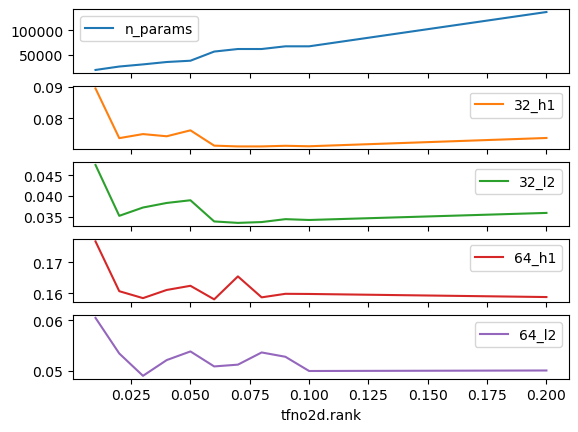

In [39]:
df_3.plot.line(x='tfno2d.rank', subplots=True)